# Model Core Utils

> core classes & helpers

In [ ]:
#| default_exp models.core

In [ ]:
#| hide
%load_ext autoreload
%autoreload 2
from nbdev.showdoc import *

In [ ]:
#| export

import torch.nn as nn
import torch
from torchmetrics import Accuracy, MaxMetric, MeanMetric
from torch_lr_finder import LRFinder

import lightning as L
from lightning.pytorch.tuner import Tuner
from lightning import Trainer
from lightning.pytorch.loggers import WandbLogger
import wandb
from lightning.pytorch.callbacks import LearningRateMonitor

from nimrod.image.datasets import ImageDataModule
from omegaconf import OmegaConf
from hydra.utils import instantiate

from abc import ABC, abstractmethod
import logging
import os
from typing import Any, Dict, List, Callable, Optional
from functools import partial

import pandas as pd
from matplotlib import pyplot as plt

logger = logging.getLogger(__name__)

## Classifier Abstract Base Class

In [ ]:
#| export

class Classifier(ABC, L.LightningModule):
    def __init__(
            self,
            nnet: nn.Module,
            num_classes:int,
            optimizer: Callable[...,torch.optim.Optimizer], # partial of optimizer
            scheduler: Optional[Callable[...,Any]]=None, # partial of scheduler
            ):

        logger.info("Classifier: init")
        super().__init__()
        self.save_hyperparameters()

        self.nnet = nnet
        self.register_module('nnet', self.nnet)
        self.lr = optimizer.keywords.get('lr') if optimizer else None # for lr finder

        self.automatic_optimization = False
        self.loss = nn.CrossEntropyLoss()
        
        self.train_acc = Accuracy(task="multiclass", num_classes=num_classes)
        self.val_acc = Accuracy(task="multiclass", num_classes=num_classes)
        self.test_acc = Accuracy(task="multiclass", num_classes=num_classes)

        self.train_loss = MeanMetric()
        self.val_loss = MeanMetric()
        self.test_loss = MeanMetric()

        self.val_acc_best = MaxMetric()
        self.step = 0

        # self.optimizer_config = None
        # self.scheduler_config = None
        # self.nnet_config = None
        

    def forward(self, x:torch.Tensor)->torch.Tensor:
        return self.nnet(x)

    def configure_optimizers(self) -> Dict[str, Any]:
        optimizer = self.hparams.optimizer(params=self.trainer.model.parameters())
        self.optimizer = optimizer
        logger.info(f"Optimizer: {optimizer.__class__}")

        if self.hparams.scheduler is None:
            logger.warning("no scheduler has been setup")
            return {"optimizer": optimizer}
        
        scheduler = self.hparams.scheduler(optimizer=optimizer)
        self.scheduler = scheduler
        logger.info(f"Scheduler: {scheduler.__class__}")

        scheduler_config = {"scheduler": scheduler}
        
        # Special handling for different scheduler types
        if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
            scheduler_config.update({
                "monitor": "val/loss",
                "interval": "epoch",
                "frequency": 1,
            })
        elif isinstance(scheduler, torch.optim.lr_scheduler.OneCycleLR):
            scheduler_config.update({
                "interval": "step",
            })
        else:
            # Default configuration for other scheduler types
            scheduler_config.update({
                "interval": "epoch",
            })
        # setup config to be able to save in wandb
        # self.optimizer_config = {
        #     'type': optimizer.__class__.__name__,
        #     'params': optimizer.defaults
        # }
        # self.scheduler_config = {
        #     'type': scheduler.__class__.__name__,
        #     'params': scheduler.__dict__
        # }
        # self.nnet_config = {
        #     'type': self.nnet.__class__.__name__,
        #     'architecture': str(self.nnet),

        # }
        # if self.logger and hasattr(self.logger, 'experiment'):
        #     self.logger.experiment.config.update({
        #         'optimizer_config': self.optimizer_config,
        #         'scheduler_config': self.scheduler_config,
        #         'nnet_config': self.nnet_config
        #     }, allow_val_change=True)

        return {
            "optimizer": optimizer,
            "lr_scheduler": scheduler_config,
        }
    
    @abstractmethod
    def _step(self, batch, batch_idx):
        pass

    @abstractmethod
    def predict_step(self, batch, batch_idx, dataloader_idx=0):
        pass

    def on_train_start(self) -> None:
        # by default lightning executes validation step sanity checks before training starts,
        # so it's worth to make sure validation metrics don't store results from these checks
        self.val_loss.reset()
        self.val_acc.reset()
        self.val_acc_best.reset()

    def training_step(self, batch, batch_idx):

        # if isinstance(self.scheduler, torch.optim.lr_scheduler.OneCycleLR):
        #     logger.info("scheduler is instance of OneCycleLR")
        #     if self.step >= self.scheduler.total_steps:
        #         logger.warning("Max steps reached for 1-cycle LR scheduler")
        #         return
        
        self.step += 1

        opt = self.optimizers() # optimizer defined in configure_optimizers
        sched = self.lr_schedulers() # access scheduler defined in configure_optimizers
         
        opt.zero_grad()
        loss, preds, y = self._step(batch, batch_idx)
        self.manual_backward(loss)
        opt.step()

        if not isinstance(sched, torch.optim.lr_scheduler.ReduceLROnPlateau):
            sched.step() #reduce plateau sched is updated at end of epoch only instead TODO: should it be applied to val loop by default?

        self.train_loss(loss)
        self.train_acc(preds, y)
        metrics = {"train/loss": self.train_loss, "train/acc": self.train_acc}
        self.log_dict(metrics, on_epoch=True, on_step=True, prog_bar=True)# Pass the validation loss to the scheduler

        return loss

    def on_train_epoch_end(self):
        pass

    def validation_step(self, batch, batch_idx, prog_bar=True, on_step=False, on_epoch=True, sync_dist=True):
        loss, preds, y = self._step(batch, batch_idx)
        self.val_loss(loss)
        self.val_acc(preds, y)
        metrics = {"val/loss":self.val_loss, "val/acc": self.val_acc}
        self.log_dict(metrics, on_step=on_step, prog_bar=prog_bar, on_epoch=on_epoch, sync_dist=sync_dist)
        return loss

    def on_validation_epoch_end(self) -> None:
        "Lightning hook that is called when a validation epoch ends."
        acc = self.val_acc.compute()  # get current val acc
        self.val_acc_best(acc)  # update best so far val acc
        # log `val_acc_best` as a value through `.compute()` method, instead of as a metric object
        # otherwise metric would be reset by lightning after each epoch
        self.log("val/acc_best", self.val_acc_best.compute(), sync_dist=True, prog_bar=True)
        
        sch = self.lr_schedulers()
        if isinstance(sch, torch.optim.lr_scheduler.ReduceLROnPlateau):
            logger.info("scheduler is an instance of Reduce plateau")
            sch.step(self.trainer.callback_metrics["val/loss"])

    def test_step(self, batch, batch_idx, prog_bar=True, on_step=False, on_epoch=True, sync_dist=True):
        loss, preds, y = self._step(batch, batch_idx)
        self.test_loss(loss)
        self.test_acc(preds, y)
        metrics = {"test/loss":self.test_loss, "test/acc": self.test_acc}
        self.log_dict(metrics, on_step=on_step, prog_bar=prog_bar, on_epoch=on_epoch, sync_dist=sync_dist)
    
    def on_test_epoch_end(self) -> None:
        """Lightning hook that is called when a test epoch ends."""
        pass


In [ ]:
#| export 

def plot_classifier_metrics_from_csv(metrics_csv_path:str | os.PathLike):
    metrics = pd.read_csv(metrics_csv_path)
    # Create figure with secondary y-axis
    fig, ax1 = plt.subplots(figsize=(10, 6))
    ax2 = ax1.twinx()

    # Plot loss
    ax1.plot(metrics['step'], metrics['train/loss_step'], 'b-', label='Train Loss')
    ax1.plot(metrics['step'], metrics['val/loss'], 'b*', label='Val Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss', color='b')
    ax1.tick_params(axis='y', labelcolor='b')

    # Plot accuracy
    ax2.plot(metrics['step'], metrics['train/acc_step'], 'r-', label='Train Acc')
    ax2.plot(metrics['step'], metrics['val/acc'], 'r*', label='Val Acc')
    ax2.set_ylabel('Accuracy', color='r')
    ax2.tick_params(axis='y', labelcolor='r')

    # Add legend
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

    plt.title('Training Metrics')
    plt.show()

## Sequential Model

In [ ]:
#| export
class SequentialModelX(Classifier):
    def __init__(self, modules: List[nn.Module], *args, **kwargs):
        super().__init__(*args, **kwargs)
        self._model = nn.Sequential(*modules)

    def forward(self, x):
        return self._model(x)

## LR Finder Helper

In [ ]:
# use LRFinder pythonm module (other version with lightning)

def find_optimal_lr(model, train_loader, criterion=None, optimizer=None, device='cuda'):
    # If no criterion provided, use default CrossEntropyLoss
    if criterion is None:
        criterion = nn.CrossEntropyLoss()
    
    # If no optimizer provided, use Adam
    if optimizer is None:
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-7, weight_decay=1e-2)
    
    # Initialize LR Finder
    lr_finder = LRFinder(model, optimizer, criterion, device=device)
    
    # Run LR range test
    lr_finder.range_test(
        train_loader, 
        start_lr=1e-7,  # Very small starting learning rate
        end_lr=10,      # Large ending learning rate
        num_iter=100,   # Number of iterations to test
        smooth_f=0.05   # Smoothing factor for the loss
    )
    
    # Plot the learning rate vs loss
    lr_finder.plot(log_lr=True)
    
    # Suggest optimal learning rate
    suggested_lr = lr_finder.reset()
    
    print(f"Suggested Learning Rate: {suggested_lr}")
    
    return suggested_lr




In [ ]:
#| export

def lr_finder(
    model: Callable[...,torch.nn.Module], # partial model (missing optim & sched)
    datamodule: ImageDataModule, # data module
    num_training:int=100, # number of iterations
    plot:bool=True # plot the learning rate vs loss
    ):

    trainer = Trainer(accelerator="auto")
    tuner = Tuner(trainer)
    optimizer = partial(torch.optim.AdamW, lr=1e-4, weight_decay=1e-5)
    model = model(optimizer=optimizer, scheduler=None)
    lr_finder = tuner.lr_find(
        model,
        datamodule=datamodule,
        min_lr=1e-5,
        max_lr=1.0,
        num_training=num_training,  # number of iterations
        # attr_name="optimizer.lr",
    )
    
    if plot:
        _ = lr_finder.plot(suggest=True)
        plt.show()
    return lr_finder.suggestion()

## 1-cycle train helper

In [ ]:
#| export

def train_one_cycle(
    model: Callable[...,torch.nn.Module], #partial model (missing optim & sched)
    datamodule: ImageDataModule,
    max_lr:float=0.1,
    weight_decay=1e-5,
    n_epochs: int=5,
    project_name:str='MNIST-Classifier',
    tags = ['arch', 'dev'],
    test:bool=True,
    run_name:str=None
    ):

    """train one cycle, adamW optim with wandb logging & learning rate monitor by default"""

    model_name = model.func.__name__ 
    if run_name is None:
        run_name = f"{model_name}-bs:{datamodule.batch_size}-epochs:{n_epochs}"

    wandb_logger = WandbLogger(
        project=project_name,
        name=run_name,
        save_dir='wandb',
        entity='slegroux',
        tags=tags,
        group=model_name,
        log_model=True, # log artefacts at the end of run
        # monitor_gym=False,
        mode='online'
        )

    lr_monitor = LearningRateMonitor(logging_interval="step")

    trainer = Trainer(
        accelerator="auto",
        max_epochs=n_epochs,
        logger=wandb_logger,
        callbacks = [lr_monitor],
        check_val_every_n_epoch=1,
        log_every_n_steps=1
        )

    total_steps = len(datamodule.train_dataloader()) * n_epochs
    optimizer = partial(torch.optim.AdamW, lr=1e-4, weight_decay=weight_decay)
    scheduler = partial(torch.optim.lr_scheduler.OneCycleLR, total_steps=total_steps, max_lr=max_lr) 
    model = model(optimizer=optimizer, scheduler=scheduler)
    
    trainer.fit(model, datamodule.train_dataloader(), datamodule.val_dataloader())
    if test:
        trainer.test(model, datamodule.test_dataloader())
    wandb.finish()


In [ ]:
#| notest

# data
cfg = OmegaConf.load('../config/data/image/fashion_mnist.yaml')
cfg.data_dir = "../data/image"
cfg.batch_size = 128
cfg.num_workers = 0
dm = instantiate(cfg)
dm.prepare_data()
dm.setup()

[23:58:03] INFO - Init ImageDataModule for fashion_mnist
[23:58:05] INFO - loading dataset fashion_mnist with args () from split train
[23:58:13] INFO - loading dataset fashion_mnist with args () from split test
[23:58:16] INFO - split train into train/val [0.8, 0.2]
[23:58:16] INFO - train: 48000 val: 12000, test: 10000


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
[23:58:19] INFO - ConvNetX: init
[23:58:19] INFO - Classifier: init
/Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'nnet' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['nnet'])`.
/Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/lightning/pytorch/loops/utilities.py:72: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
[23:58:22] INFO - loading dataset fashion_mnist with args () from split train
[23:58:29] INFO - loading dataset fashion_mnist with args () from split test
[23:58:32] INFO - Optimizer: <class 'torch.optim.adamw.AdamW'>
[23:58:32] WARNING - no scheduler has been setup


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.017782794100389233
Restoring states from the checkpoint path at /Users/slegroux/Projects/nimrod/nbs/.lr_find_7fd77c6c-bbb1-41cd-9b21-1c4e917ac6d9.ckpt
Restored all states from the checkpoint at /Users/slegroux/Projects/nimrod/nbs/.lr_find_7fd77c6c-bbb1-41cd-9b21-1c4e917ac6d9.ckpt


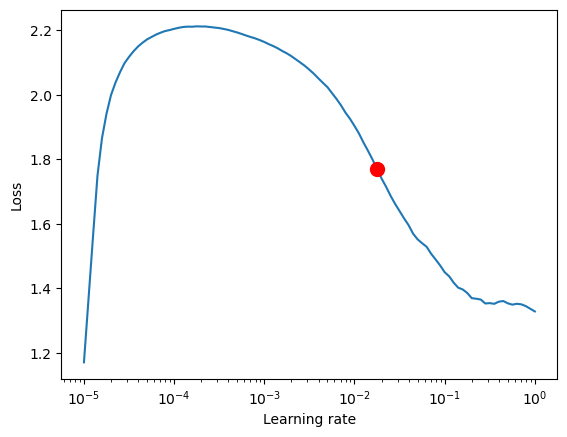

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
[23:58:36] INFO - ConvNetX: init
[23:58:36] INFO - Classifier: init


[23:58:38] INFO - Optimizer: <class 'torch.optim.adamw.AdamW'>
[23:58:38] INFO - Scheduler: <class 'torch.optim.lr_scheduler.OneCycleLR'>

  | Name         | Type               | Params | Mode 
------------------------------------------------------------
0 | nnet         | ConvNet            | 45.9 K | train
1 | loss         | CrossEntropyLoss   | 0      | train
2 | train_acc    | MulticlassAccuracy | 0      | train
3 | val_acc      | MulticlassAccuracy | 0      | train
4 | test_acc     | MulticlassAccuracy | 0      | train
5 | train_loss   | MeanMetric         | 0      | train
6 | val_loss     | MeanMetric         | 0      | train
7 | test_loss    | MeanMetric         | 0      | train
8 | val_acc_best | MaxMetric          | 0      | train
------------------------------------------------------------
45.9 K    Trainable params
0         Non-trainable params
45.9 K    Total params
0.184     Total estimated model params size (MB)
39        Modules in train mode
0         Modules in eval m

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.
/Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/acc          │    0.8992000222206116     │
│         test/loss         │    0.27419397234916687    │
└───────────────────────────┴───────────────────────────┘

epoch,▁▁▁▁▁▁▁▁▁▁▃▃▃▃▃▃▃▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆███████
lr-AdamW,▁▂▂▃▃▅▆▇▇██████▇▇▇▇▇▆▆▅▅▅▅▅▄▃▃▃▂▂▁▁▁▁▁▁▁
test/acc,▁
test/loss,▁
train/acc_epoch,▁▆▇██
train/acc_step,▁▆▆▆▆▆▆▆▇▆▇▇█▇▇▇▇▇▇█▇█▇▇██████████████▇█
train/loss_epoch,█▂▁▁▁
train/loss_step,████▇▇▆▆▅▃▂▂▂▂▂▂▂▁▁▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇██
val/acc,▁▅▆██
val/acc_best,▁▅▆██


In [ ]:
#| notest
# model
cfg_model = OmegaConf.load('../config/model/image/convnetx.yaml')
feats_dim = [1, 8, 16, 32, 64, 32]
# feats_dim = [1, 4, 8, 16, 8]
# feats_dim = [1, 16, 32, 64, 32]
cfg_model.nnet.n_features = feats_dim
model = instantiate(cfg_model) #partial

lr = lr_finder(model=model, datamodule=dm, plot=True)

# train
N_EPOCHS = 5
suggested_lr = 1e-3
project_name = "FASHION-MNIST-Classifier"
run_name = f"{model.func.__name__}-bs:{dm.batch_size}-epochs:{N_EPOCHS}"
tags = [f"feats:{feats_dim}", f"bs:{dm.batch_size}", f"epochs:{N_EPOCHS}"]

train_one_cycle(
    model,
    dm,
    n_epochs=N_EPOCHS,
    max_lr=suggested_lr,
    project_name=project_name,
    tags=tags,
    run_name=run_name
    )

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()